Using device: cpu
Unique words in corpus: 35177
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


C:\Users\admin\AppData\Local\Temp\ipykernel_17676\3909622494.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = data.groupby("Sentence #", group_keys=False).apply(


Epoch [1/3] - Train Loss: 0.8053 | Val Loss: 0.5458
Epoch [2/3] - Train Loss: 0.4215 | Val Loss: 0.4616
Epoch [3/3] - Train Loss: 0.2992 | Val Loss: 0.4498

Classification Report:



C:\Users\admin\.conda\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\.conda\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\.conda\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

              precision    recall  f1-score   support

       B-art       1.00      0.04      0.08        96
       B-eve       0.73      0.38      0.50        78
       B-geo       0.87      0.90      0.89      7377
       B-gpe       0.94      0.93      0.94      3176
       B-nat       0.69      0.62      0.66        40
       B-org       0.80      0.75      0.77      3907
       B-per       0.82      0.84      0.83      3362
       B-tim       0.93      0.94      0.93      4104
       I-art       0.00      0.00      0.00        86
       I-eve       0.50      0.17      0.26        70
       I-geo       0.83      0.78      0.81      1448
       I-gpe       0.89      0.52      0.65        33
       I-nat       0.86      0.43      0.57        14
       I-org       0.80      0.85      0.82      3252
       I-per       0.86      0.87      0.86      3423
       I-tim       0.89      0.84      0.86      1341

    accuracy                           0.86     31807
   macro avg       0.78   

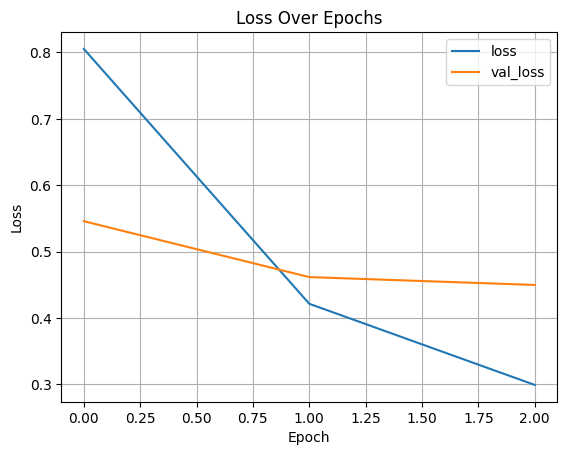

Name:clarissa k 
Register Number:212224230047
Word            True       Pred
----------------------------------------
Palestinian     B-gpe      B-gpe
officials       O          B-per
say             O          B-gpe
two             O          B-tim
Palestinians    B-gpe      B-gpe
have            O          B-gpe
been            O          B-per
killed          O          B-geo
in              O          I-tim
an              O          B-tim
accidental      O          B-geo
explosion       O          I-geo
in              O          I-tim
a               O          B-geo
West            B-org      B-org
Bank            I-org      I-org
refugee         O          I-org
camp            O          I-org
.               O          B-tim


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Load and prepare data
# -------------------------------
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
print("Unique tags are:", tags)

# -------------------------------
# Group words by sentences
# -------------------------------
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

# Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

# Pad sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

# -------------------------------
# Dataset class
# -------------------------------
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

# -------------------------------
# Model definition
# -------------------------------
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, input_ids):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc(lstm_out)
        return out

# -------------------------------
# Initialize model, loss, optimizer
# -------------------------------
vocab_size = len(word2idx) + 1
tagset_size = len(tag2idx)
model = BiLSTMTagger(vocab_size, tagset_size).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tag2idx["O"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# Training and Evaluation
# -------------------------------
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)

            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])

    print("\nClassification Report:\n")
    print(classification_report(true_tags, pred_tags))

# -------------------------------
# Run training and evaluation
# -------------------------------
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)

# -------------------------------
# Plot loss
# -------------------------------
print('Name:                 ')
print('Register Number:      ')
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# -------------------------------
# Inference and prediction
# -------------------------------
i = 125
model.eval()
sample = X_test[i].unsqueeze(0).to(device)
output = model(sample)
preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
true = y_test[i].numpy()

print('Name:clarissa k ')
print('Register Number:212224230047')
print("{:<15} {:<10} {}\n{}".format("Word", "True", "Pred", "-" * 40))
for w_id, true_tag, pred_tag in zip(X_test[i], y_test[i], preds):
    if w_id.item() != word2idx["ENDPAD"]:
        word = words[w_id.item() - 1]
        true_label = tags[true_tag.item()]
        pred_label = tags[pred_tag]
        print(f"{word:<15} {true_label:<10} {pred_label}")
